In [1]:
import numpy as np
import pandas as pd
import hopsworks

In [2]:
api_key = "0b0gacHtuxlM0qhD.bgtKsMK0QwfIMrewQ6UCSwgan9uZVakm3XXOsukIq8rAEFqnVKGQveqtReSEoeBu"

project = hopsworks.login(api_key_value=api_key, project="ID2223HT24G4" )
fs = project.get_feature_store()

2025-01-08 16:01:19,132 INFO: Initializing external client
2025-01-08 16:01:19,134 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 16:01:20,661 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1167511


In [3]:
feature_view = fs.get_feature_view(name="rate_vix_bzf_omx_feature_view", version=1)
data = feature_view.get_batch_data()
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

df = data.copy()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.46s) from Hopsworks, using Hopsworks Feature Query Service.   


In [4]:
# Example: Create day+1 through day+7
df["rate_plus_1d"] = df["rate"].shift(-1)
df["rate_plus_2d"] = df["rate"].shift(-2)
df["rate_plus_3d"] = df["rate"].shift(-3)
df["rate_plus_4d"] = df["rate"].shift(-4)
df["rate_plus_5d"] = df["rate"].shift(-5)
df["rate_plus_6d"] = df["rate"].shift(-6)
df["rate_plus_7d"] = df["rate"].shift(-7)

# Drop rows with NaN
df.dropna(inplace=True)

df.head()


,date,rate,vix,omx,bzf,rate_plus_1d,rate_plus_2d,rate_plus_3d,rate_plus_4d,rate_plus_5d,rate_plus_6d,rate_plus_7d
312,2010-12-01 00:00:00+00:00,7.0246,21.360001,1134.270020,88.870003,6.9743,6.90190,6.79270,6.85250,6.89600,6.87713,6.8926
555,2010-12-02 00:00:00+00:00,6.9743,19.389999,1145.510010,90.690002,6.9019,6.79270,6.85250,6.89600,6.87713,6.89260,6.9214
1709,2010-12-03 00:00:00+00:00,6.9019,18.010000,1149.560059,91.419998,6.7927,6.85250,6.89600,6.87713,6.89260,6.92140,6.8237
3307,2010-12-06 00:00:00+00:00,6.7927,18.020000,1144.439941,91.449997,6.8525,6.89600,6.87713,6.89260,6.92140,6.82370,6.8076
793,2010-12-07 00:00:00+00:00,6.8525,17.990000,1148.979980,91.389999,6.8960,6.87713,6.89260,6.92140,6.82370,6.80760,6.8376


In [5]:
train_mask = df['date'] < "2023-01-01"
val_mask   = (df["date"] >= "2023-01-01") & (df["date"] < "2024-01-01")
test_mask  = df["date"] >= "2024-01-01"

df_train = df[train_mask].copy()
df_val   = df[val_mask].copy()
df_test  = df[test_mask].copy()

FEATURE_COLS = ["rate", "vix", "omx", "bzf"]  # adapt as needed
LABEL_COL = [
    "rate_plus_1d",
    "rate_plus_2d",
    "rate_plus_3d",
    "rate_plus_4d",
    "rate_plus_5d",
    "rate_plus_6d",
    "rate_plus_7d",
]


X_train = df_train[FEATURE_COLS].values
y_train = df_train[LABEL_COL].values

X_val   = df_val[FEATURE_COLS].values
y_val   = df_val[LABEL_COL].values

X_test  = df_test[FEATURE_COLS].values
y_test  = df_test[LABEL_COL].values

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape,   y_val.shape)
print("Test shape: ", X_test.shape,  y_test.shape)


Train shape: (2918, 4) (2918, 7)
Val shape:   (243, 4) (243, 7)
Test shape:  (243, 4) (243, 7)


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Scale features
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)  # fit only on train
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

# Scale labels
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)  # fit on (N,2) for day+1, day+7
y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

print("Scaled shapes:", X_train_scaled.shape, y_train_scaled.shape)


Scaled shapes: (2918, 4) (2918, 7)


In [7]:
def create_sequences(X, Y, seq_len=30):
    """
    X: shape (N, num_features)
    Y: shape (N, 7)  # if we are predicting 7 days
    Returns:
      X_seq: (N - seq_len, seq_len, num_features)
      Y_seq: (N - seq_len, 7)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])
        ys.append(Y[i + seq_len - 1])
    return np.array(Xs), np.array(ys)

sequence_length = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   sequence_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  sequence_length)

print("X_train_seq:", X_train_seq.shape)  
print("y_train_seq:", y_train_seq.shape)  


X_train_seq: (2888, 30, 4)
y_train_seq: (2888, 7)


In [8]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_model(hp):
    model = Sequential()

    # First LSTM
    model.add(Bidirectional(
        LSTM(
            units=hp.Int("units_lstm1", min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(sequence_length, len(FEATURE_COLS))
        )
    ))
    model.add(Dropout(hp.Float("dropout_lstm1", 0.1, 0.5, step=0.2)))

    # Second LSTM
    model.add(LSTM(
        units=hp.Int("units_lstm2", min_value=16, max_value=64, step=16),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float("dropout_lstm2", 0.1, 0.5, step=0.2)))

    model.add(Dense(7))

    # Compile
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )
    return model


In [9]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,  
    directory="my_lstm_tuning",
    project_name="multi_output_7days"
)

tuner.search(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )
    ]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best HPs:", best_hps.values)

best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_mae = best_model.evaluate(X_test_seq, y_test_seq)
print("Test Loss (MSE):", test_loss, "Test MAE:", test_mae)


Trial 5 Complete [00h 00m 17s]
val_loss: 0.0015140867326408625

Best val_loss So Far: 0.0014124991139397025
Total elapsed time: 00h 01m 21s
Best HPs: {'units_lstm1': 64, 'dropout_lstm1': 0.1, 'units_lstm2': 16, 'dropout_lstm2': 0.1, 'learning_rate': 0.0015453316687064683}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0294  
Test Loss (MSE): 0.0015996196307241917 Test MAE: 0.03331706300377846


In [12]:
y_pred_scaled = best_model.predict(X_test_seq)  # shape: (num_test_seq, 2)

# Inverse transform to original units
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


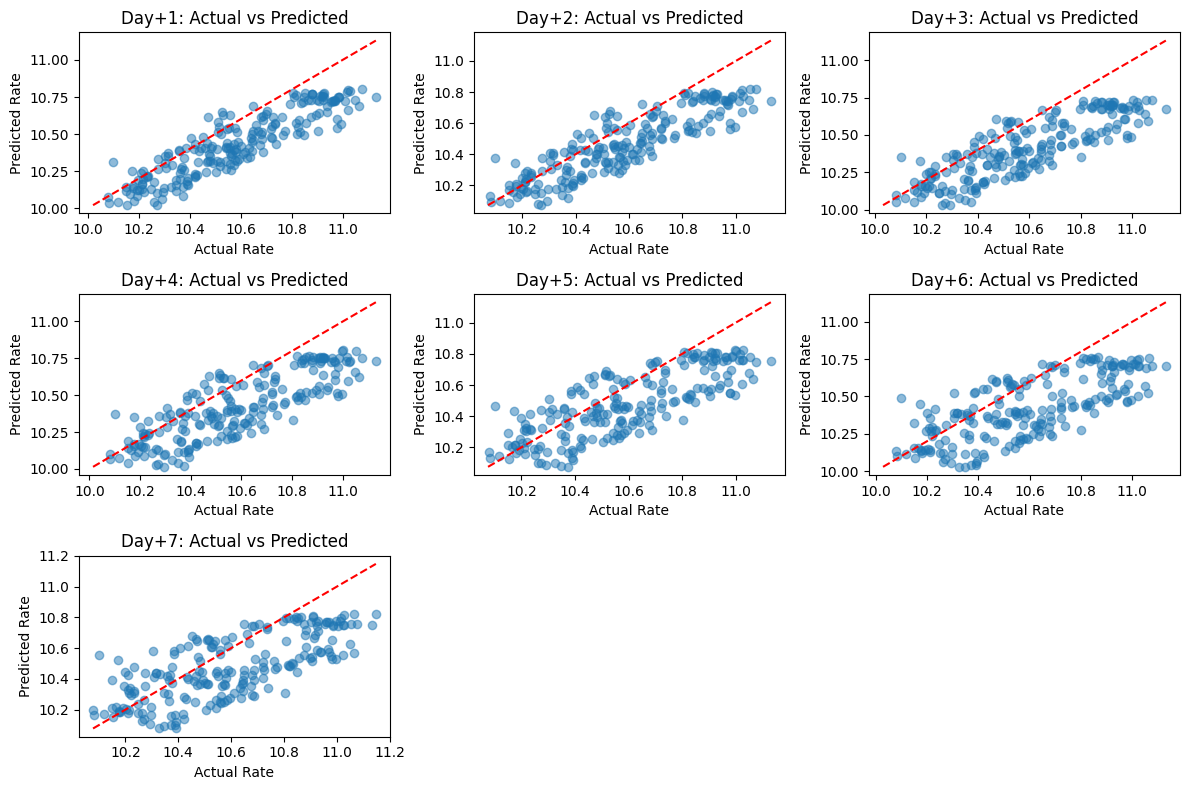

In [13]:
import matplotlib.pyplot as plt

days_to_plot = [1, 2, 3, 4, 5, 6, 7] 

plt.figure(figsize=(12, 8))
for i, d in enumerate(days_to_plot, start=1):
    plt.subplot(3, 3, i)
    plt.scatter(y_true[:, d-1], y_pred[:, d-1], alpha=0.5)
    plt.title(f"Day+{d}: Actual vs Predicted")
    plt.xlabel("Actual Rate")
    plt.ylabel("Predicted Rate")
    # line y=x
    mn = min(y_true[:, d-1].min(), y_pred[:, d-1].min())
    mx = max(y_true[:, d-1].max(), y_pred[:, d-1].max())
    plt.plot([mn, mx], [mn, mx], 'r--')
plt.tight_layout()
plt.show()


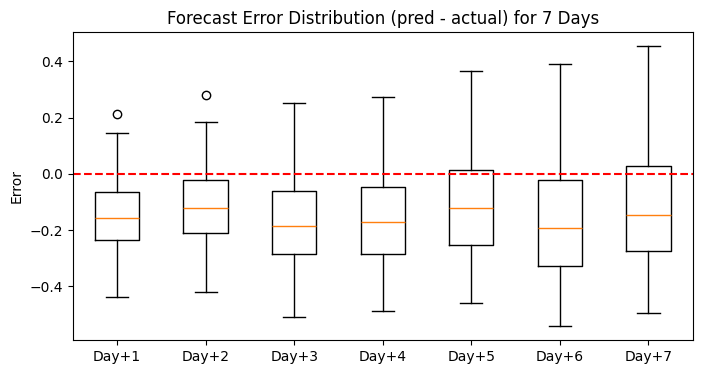

In [14]:
import matplotlib.pyplot as plt


errors_list = []
for i in range(7):
    day_errors = y_pred[:, i] - y_true[:, i]  # pred - actual
    errors_list.append(day_errors)

plt.figure(figsize=(8,4))
plt.boxplot(errors_list, labels=[f"Day+{i+1}" for i in range(7)])
plt.axhline(0, color='red', linestyle='--')
plt.title("Forecast Error Distribution (pred - actual) for 7 Days")
plt.ylabel("Error")
plt.show()


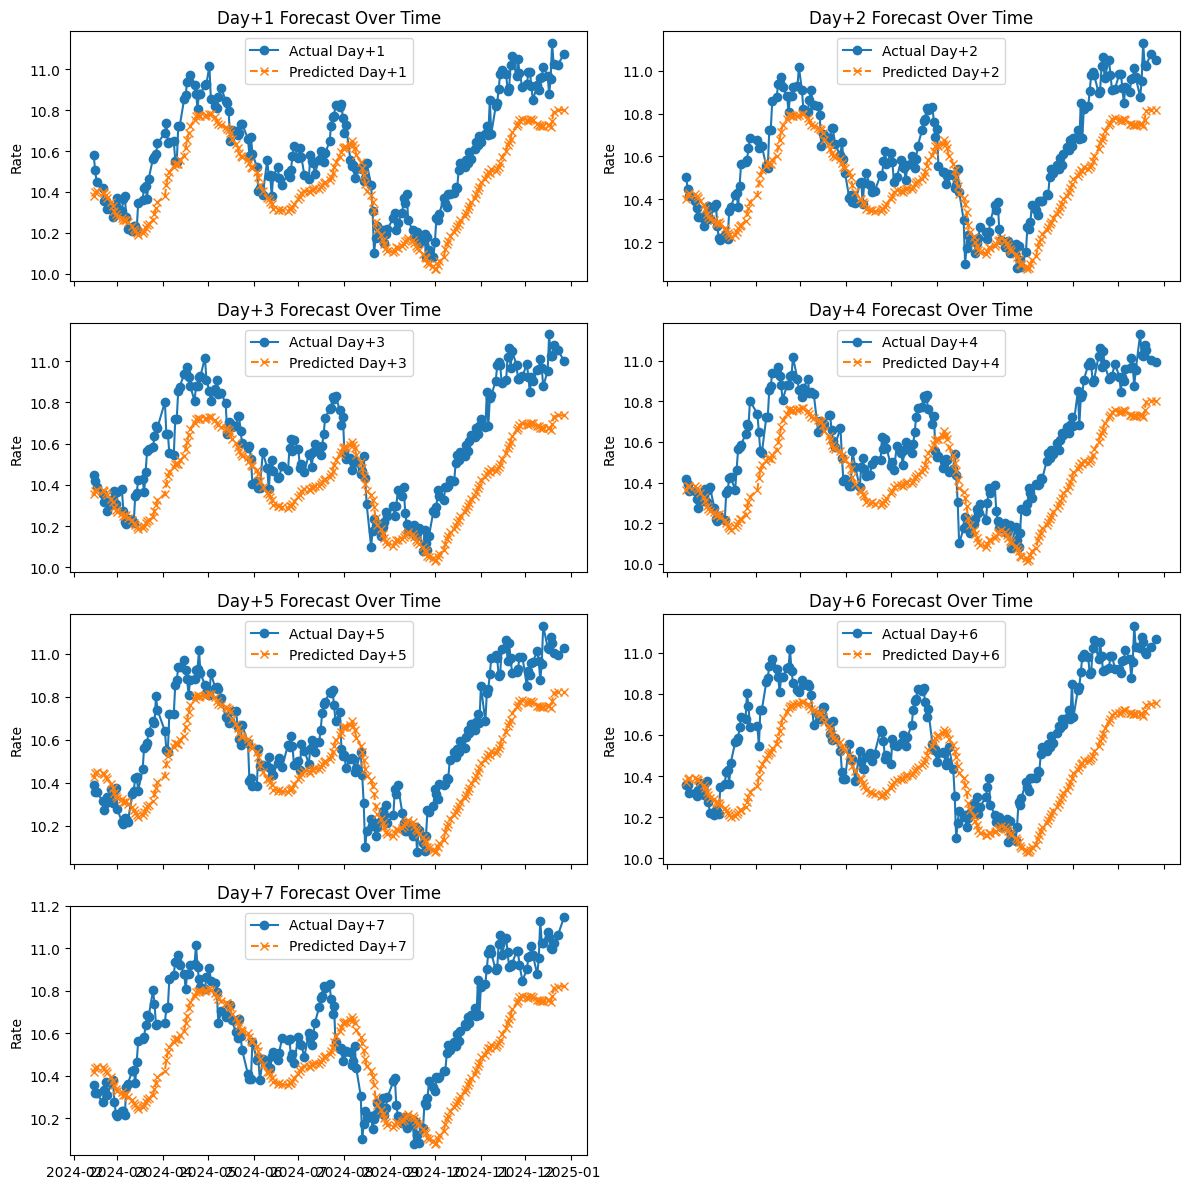

In [16]:
test_dates = df_test["date"].values  # shape (N_test, )
sequence_length = 30
dates_seq = test_dates[sequence_length:]  # offset to align with X_test_seq
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True)
axes = axes.ravel()  # flatten into 1D list [ax0, ax1, ..., ax7]

for i in range(7):
    ax = axes[i]
    ax.plot(dates_seq, y_true[:, i], 'o-', label=f'Actual Day+{i+1}')
    ax.plot(dates_seq, y_pred[:, i], 'x--', label=f'Predicted Day+{i+1}')
    ax.set_title(f"Day+{i+1} Forecast Over Time")
    ax.set_ylabel("Rate")
    ax.legend()

# Turn off the 8th subplot if you only have 7 days, or adjust the layout
axes[-1].set_visible(False)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:

X_full = np.concatenate([X_train, X_val, X_test], axis=0)
y_full = np.concatenate([y_train, y_val, y_test], axis=0)
scaler_X_full = MinMaxScaler()
scaler_X_full.fit(X_full)
X_full_scaled = scaler_X_full.transform(X_full)

scaler_y_full = MinMaxScaler()
scaler_y_full.fit(y_full)
y_full_scaled = scaler_y_full.transform(y_full)

sequence_length = 30
X_full_seq, y_full_seq = create_sequences(X_full_scaled, y_full_scaled, sequence_length)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

model_retrain = build_model(best_hps)

model_retrain.fit(
    X_full_seq,
    y_full_seq,
    epochs=20,      #
    batch_size=32,   
    verbose=1
)


Epoch 1/20


106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0600 - mae: 0.1661
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0078 - mae: 0.0602
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0059 - mae: 0.0533
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0048 - mae: 0.0481
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0040 - mae: 0.0448
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0036 - mae: 0.0429
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032 - mae: 0.0403
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0027 - mae: 0.0376
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0023 - mae: 0.0349
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0024 - mae: 0.0360
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0021 - mae: 0.0335
Epoch 12/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0021 - mae: 0.0332
Epoch 13/20
106/106 ━━━━

In [23]:
import joblib

mr = project.get_model_registry()


local_model_dir = "7day_lstm_model_v2"
!mkdir -p $local_model_dir 

model_file = local_model_dir + "/rates_lstm_model_v2.keras"
model_retrain.save(model_file)  

scaler_file_X = local_model_dir + "/scaler_x_v2.pkl"
joblib.dump(scaler_X_full, scaler_file_X)

scaler_file_y = local_model_dir + "/scaler_y_v2.pkl"
joblib.dump(scaler_y_full, scaler_file_y)

model_meta = mr.python.create_model(
    name="lstm_rate_vix_omx_bzf_7day_v2",
    description="LSTM for 7-day forecast of rate and vix+omx+bzf, including scaler"
)

model_meta.save(local_model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/959 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/584197 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/823 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1167511/models/lstm_rate_vix_omx_bzf_7day_v2/1


Model(name: 'lstm_rate_vix_omx_bzf_7day_v2', version: 1)

Model and scaler successfully saved to Hopsworks Model Registry!
